<a href="https://colab.research.google.com/github/Jackson00Han/Time-Series-Training/blob/main/Univariate_time_series_with_exogenous_variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Description
This is an example of univariate time series with exogenous variables.

In this project, we assume other variables's future values but pm2.5 can be forecasted, therefore they are exogenous variables. PM2.5 is the target variable.



### Data Info

No: This is the row number or record index.

year: The year of the observation, in this example it is 2010.

month: The month of the observation, in this case, January.

day: The day of the observation, indicating the specific day of the month.

hour: The hour of the observation, using a 24-hour format (e.g., 0 represents midnight, 1 represents 1 AM).

pm2.5: The concentration of PM2.5 (fine particulate matter) in the air, possibly measured in micrograms per cubic meter (μg/m³). In this data segment, some values are missing (denoted as NA).

DEWP: Dew point temperature in degrees Celsius (°C), which indicates the temperature at which air becomes saturated and dew forms.

TEMP: The actual air temperature, measured in degrees Celsius (°C).

PRES: Atmospheric pressure, measured in hectopascals (hPa).

cbwd: Coded wind direction, shown as abbreviations like NW for northwest wind.

Iws: Cumulative wind speed, possibly measured in meters per second (m/s).

Is: Cumulative precipitation, possibly measured in millimeters (mm). In this data segment, all values are 0, indicating no precipitation.

Ir: Cumulative snowfall, possibly measured in millimeters (mm). In this data segment, all values are 0, indicating no snowfall.

## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('pollution.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [3]:
# Convert numeric columns to strings before concatenation
df['datetime'] = df['year'].astype(str) + '-' + df['month'].astype(str) + '-' + \
                 df['day'].astype(str) + ' ' + df['hour'].astype(str) + ':00'

df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime'] = df['datetime'].dt.strftime('%Y-%m-%d %H')
df.drop(['year', 'month', 'day', 'hour'], axis=1, inplace=True)
df.set_index('datetime', inplace=True)
df.drop(['No'], axis=1, inplace=True)
df.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
datetime,,,,,,,,
2010-01-01 00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04,NaN,-20,-12.0,1018.0,NW,12.97,0,0


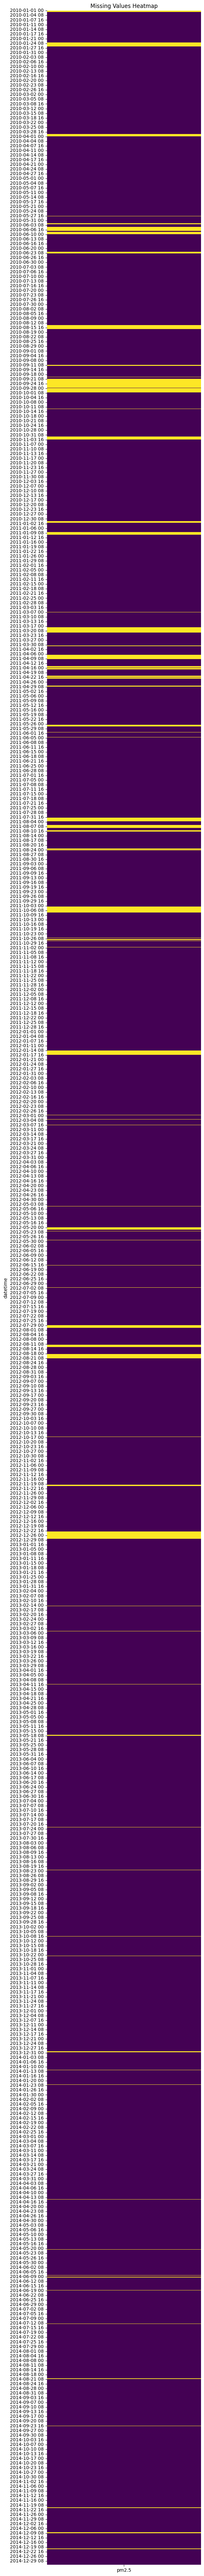

In [4]:
# Visualizing the missing values
plt.figure(figsize=(6,100))
sns.heatmap(df['pm2.5'].isnull().to_frame(), cbar=False, cmap='viridis')  # Convert Series to DataFrame
plt.title('Missing Values Heatmap')
plt.show()

In [5]:
# Only use the last two years's data

df = df.loc[df.index > '2012-12-31 23'].copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17520 entries, 2013-01-01 00 to 2014-12-31 23
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pm2.5   17339 non-null  float64
 1   DEWP    17520 non-null  int64  
 2   TEMP    17520 non-null  float64
 3   PRES    17520 non-null  float64
 4   cbwd    17520 non-null  object 
 5   Iws     17520 non-null  float64
 6   Is      17520 non-null  int64  
 7   Ir      17520 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.2+ MB


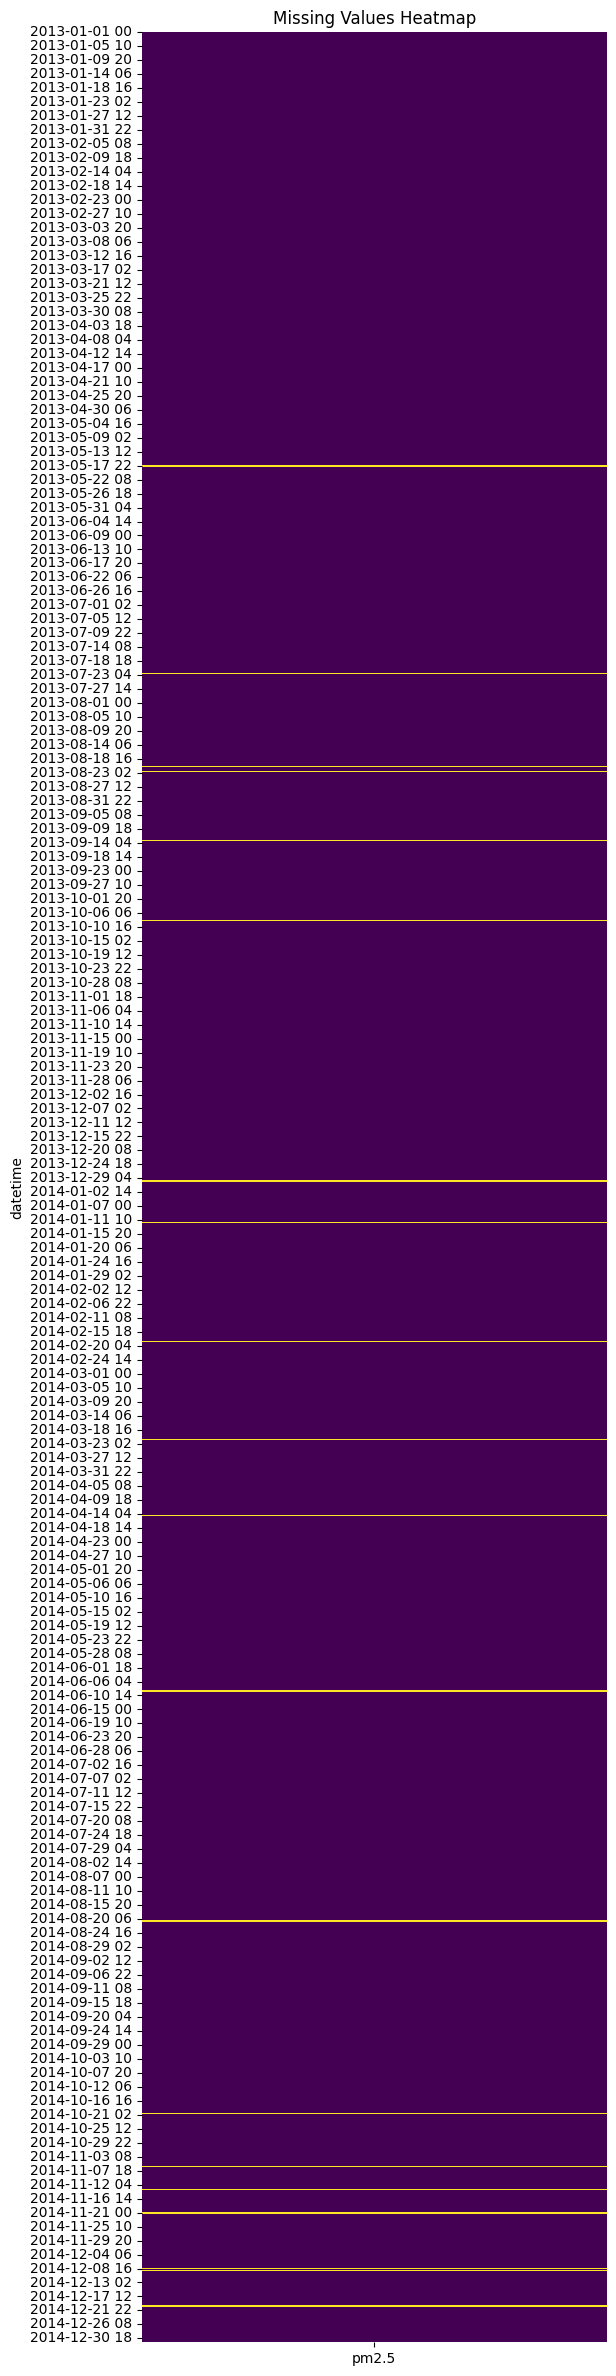

In [7]:
# visualize the missing values again
plt.figure(figsize=(6,30))
sns.heatmap(df['pm2.5'].isnull().to_frame(), cbar=False, cmap='viridis')  # Convert Series to DataFrame
plt.title('Missing Values Heatmap')
plt.show()

In [8]:
# Dealing with missing values
df['pm2.5'].interpolate(method='linear', inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17520 entries, 2013-01-01 00 to 2014-12-31 23
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pm2.5   17520 non-null  float64
 1   DEWP    17520 non-null  int64  
 2   TEMP    17520 non-null  float64
 3   PRES    17520 non-null  float64
 4   cbwd    17520 non-null  object 
 5   Iws     17520 non-null  float64
 6   Is      17520 non-null  int64  
 7   Ir      17520 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.2+ MB


In [10]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['cbwd'], drop_first=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17520 entries, 2013-01-01 00 to 2014-12-31 23
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   pm2.5    17520 non-null  float64
 1   DEWP     17520 non-null  int64  
 2   TEMP     17520 non-null  float64
 3   PRES     17520 non-null  float64
 4   Iws      17520 non-null  float64
 5   Is       17520 non-null  int64  
 6   Ir       17520 non-null  int64  
 7   cbwd_NW  17520 non-null  bool   
 8   cbwd_SE  17520 non-null  bool   
 9   cbwd_cv  17520 non-null  bool   
dtypes: bool(3), float64(4), int64(3)
memory usage: 1.1+ MB


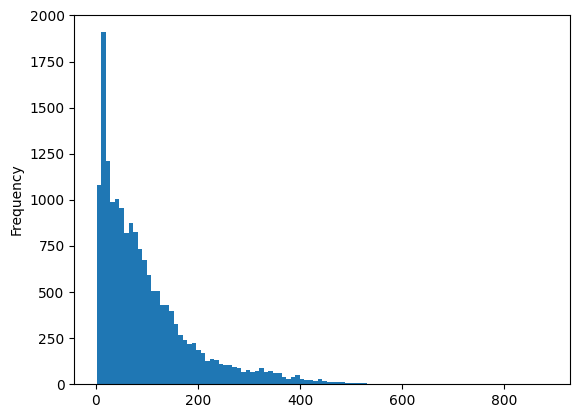

In [12]:
df['pm2.5'].plot(kind='hist', bins=100)
plt.show()

Since the PM2.5 is right-skewed, we apply a log transformation to normalize the distribution.

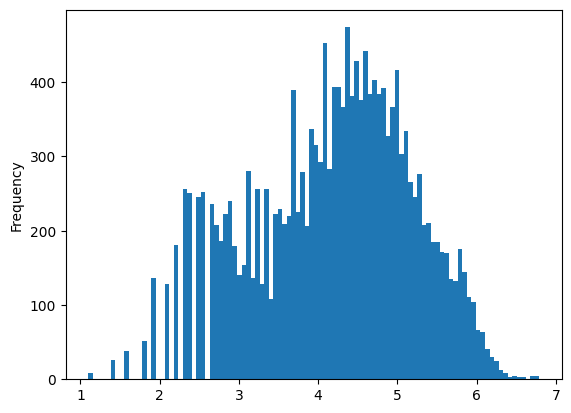

In [13]:
df['pm2.5_log'] = np.log1p(df['pm2.5'])
df['pm2.5_log'].plot(kind='hist', bins=100)
plt.show()

## EDA

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17520 entries, 2013-01-01 00 to 2014-12-31 23
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pm2.5      17520 non-null  float64
 1   DEWP       17520 non-null  int64  
 2   TEMP       17520 non-null  float64
 3   PRES       17520 non-null  float64
 4   Iws        17520 non-null  float64
 5   Is         17520 non-null  int64  
 6   Ir         17520 non-null  int64  
 7   cbwd_NW    17520 non-null  bool   
 8   cbwd_SE    17520 non-null  bool   
 9   cbwd_cv    17520 non-null  bool   
 10  pm2.5_log  17520 non-null  float64
dtypes: bool(3), float64(5), int64(3)
memory usage: 1.3+ MB


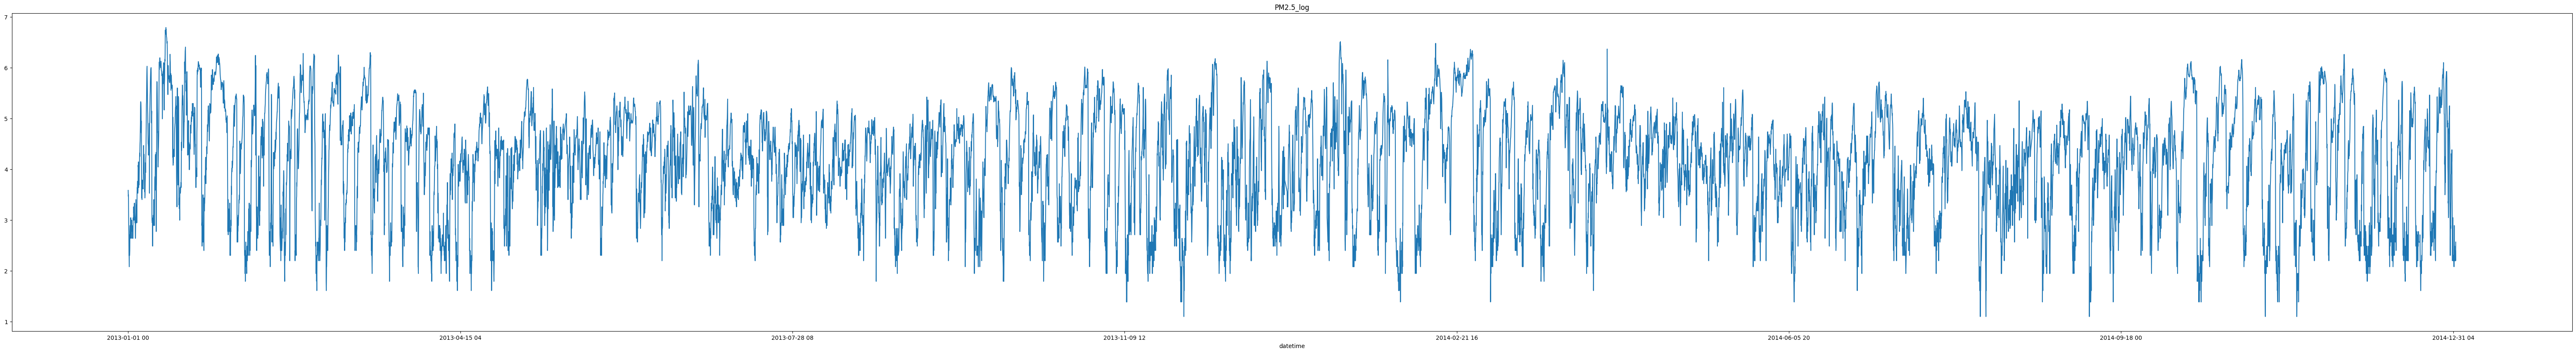

In [15]:
fig, ax = plt.subplots(figsize=(80, 10))
df['pm2.5_log'].plot(ax=ax)
ax.set_title('PM2.5_log')
plt.show()

In [16]:
sample = df.loc[:'2013-12-31 23']

In [26]:
train = df.iloc[:-30*100]
test = df.iloc[-30*100:]

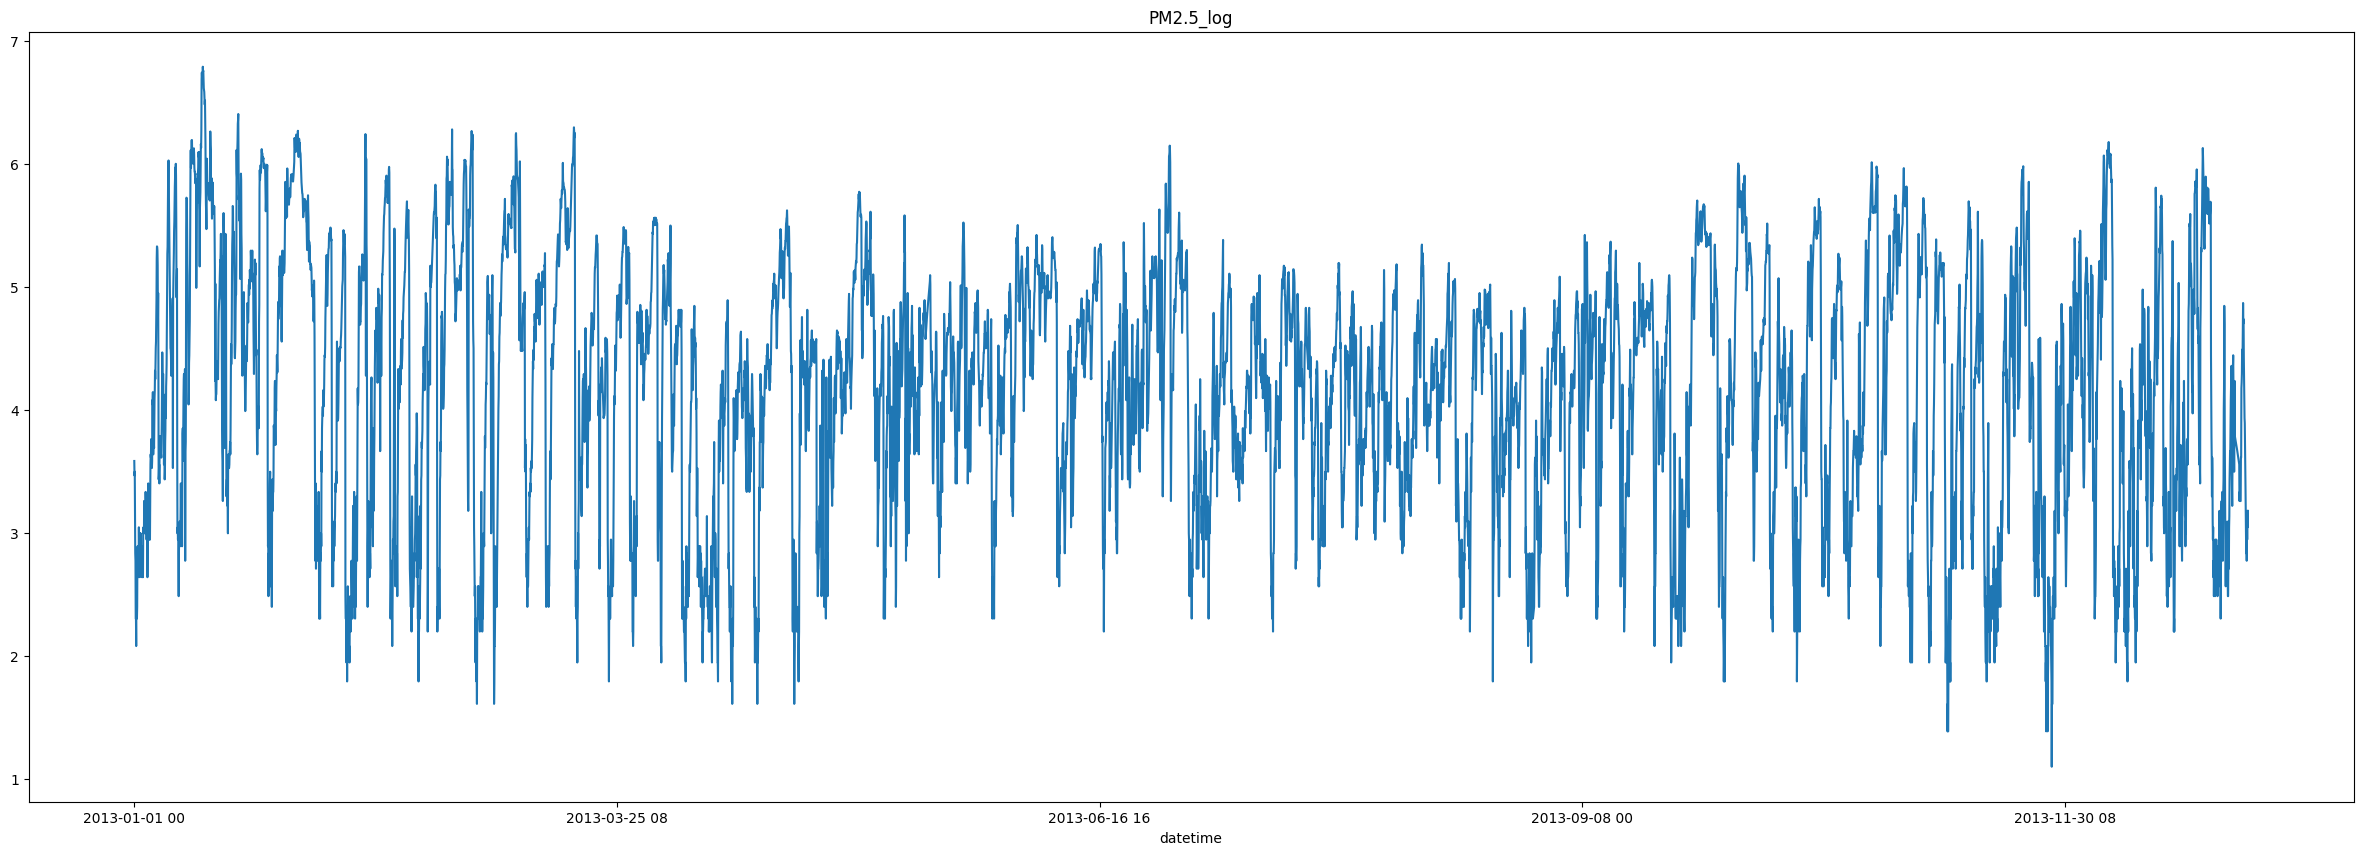

In [17]:
fig, ax = plt.subplots(figsize=(30, 10))
sample['pm2.5_log'].plot(ax=ax)
ax.set_title('PM2.5_log')
plt.show()

In [18]:
from statsmodels.tsa.stattools import adfuller
result1 = adfuller(sample['pm2.5_log'])
print('ADF Statistic: %f' % result1[0])
print('p-value: %f' % result1[1])

ADF Statistic: -15.083697
p-value: 0.000000


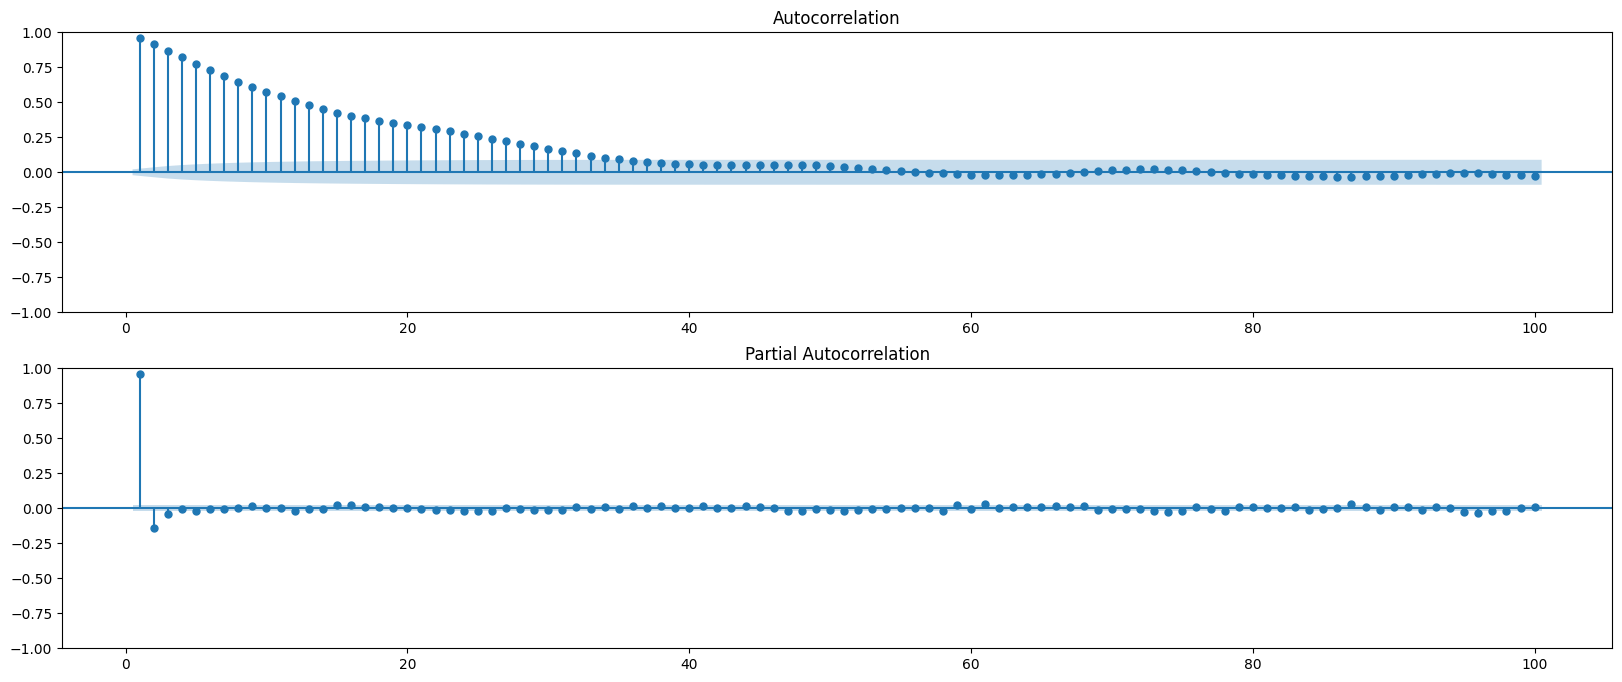

In [19]:
fig, axs = plt.subplots(2,1, figsize=(20, 8))
plot_acf(sample['pm2.5_log'], ax=axs[0], zero=False, lags=100)
plot_pacf(sample['pm2.5_log'], ax=axs[1], zero=False, lags=100)
plt.show()

The above figure show that p=1,2, q=0, d=0.

## Model training

In [20]:
df.columns

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5_log'],
      dtype='object')

In [27]:
train.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5_log
datetime,,,,,,,,,,,
2013-01-01 00,35.0,-10,-5.0,1018.0,5.81,0,0,True,False,False,3.583519
2013-01-01 01,31.0,-11,-7.0,1017.0,9.83,0,0,True,False,False,3.465736
2013-01-01 02,32.0,-11,-7.0,1017.0,11.62,0,0,True,False,False,3.496508
2013-01-01 03,21.0,-14,-10.0,1018.0,14.75,0,0,True,False,False,3.091042
2013-01-01 04,16.0,-15,-10.0,1018.0,0.45,0,0,False,False,True,2.833213


In [73]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the exogenous variables
exogs = df[['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']]

# Fit the SARIMAX model with exogenous variables
model = SARIMAX(train['pm2.5_log'], order=(1, 1, 0))
results = model.fit()

# Print the summary of the model
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:              pm2.5_log   No. Observations:                14520
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1524.829
Date:                Mon, 19 Aug 2024   AIC                           3053.659
Time:                        21:18:20   BIC                           3068.825
Sample:                    01-01-2013   HQIC                          3058.699
                         - 08-28-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1028      0.005     22.082      0.000       0.094       0.112
sigma2         0.0722      0.000    223.160      0.000       0.072       0.073
Ljung-Box (L1) (Q):                   0.07   Jarque-

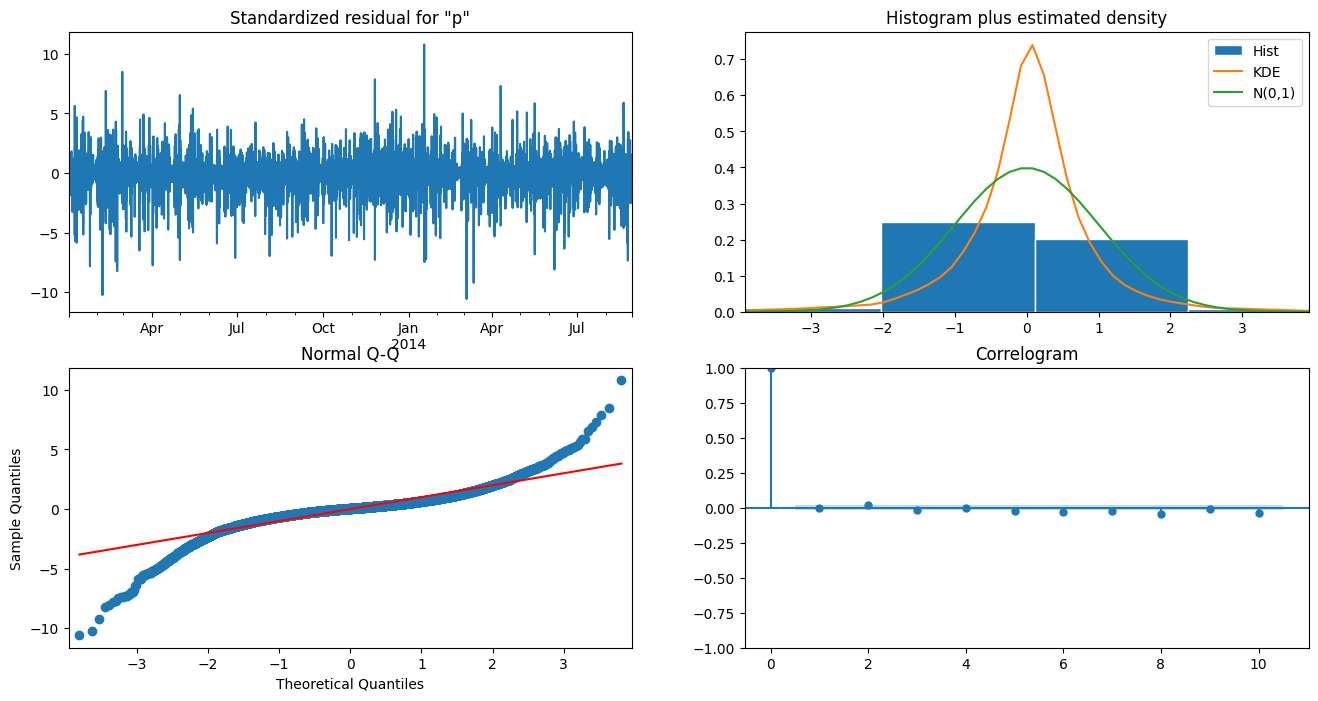

In [74]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [75]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Generate predictions
# Generate predictions
forecast = results.get_prediction(start=-100).predicted_mean
# Evaluation
mae = mean_absolute_error(forecast,train['pm2.5_log'][-100:])
mse = mean_squared_error(forecast, train['pm2.5_log'][-100:])
print(mae)
print(mse)

0.20340458219301039
0.0724994363517206


Now, let's include exogenous variables

In [76]:
# Fit the SARIMAX model with exogenous variables

# Define the exogenous variables
exogs = train[['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']]
exogs[['cbwd_NW', 'cbwd_SE', 'cbwd_cv']] = exogs[['cbwd_NW', 'cbwd_SE', 'cbwd_cv']].astype(int)
model = SARIMAX(train['pm2.5_log'], order=(1, 1, 0), exog=exogs)
results = model.fit()

# Print the summary of the model
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:              pm2.5_log   No. Observations:                14520
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1296.904
Date:                Mon, 19 Aug 2024   AIC                           2615.807
Time:                        21:19:47   BIC                           2699.223
Sample:                    01-01-2013   HQIC                          2643.528
                         - 08-28-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DEWP           0.0307      0.001     28.935      0.000       0.029       0.033
TEMP          -0.0046      0.001     -3.557      0.000      -0.007      -0.002
PRES          -0.0006      0.003     -0.217      0.8

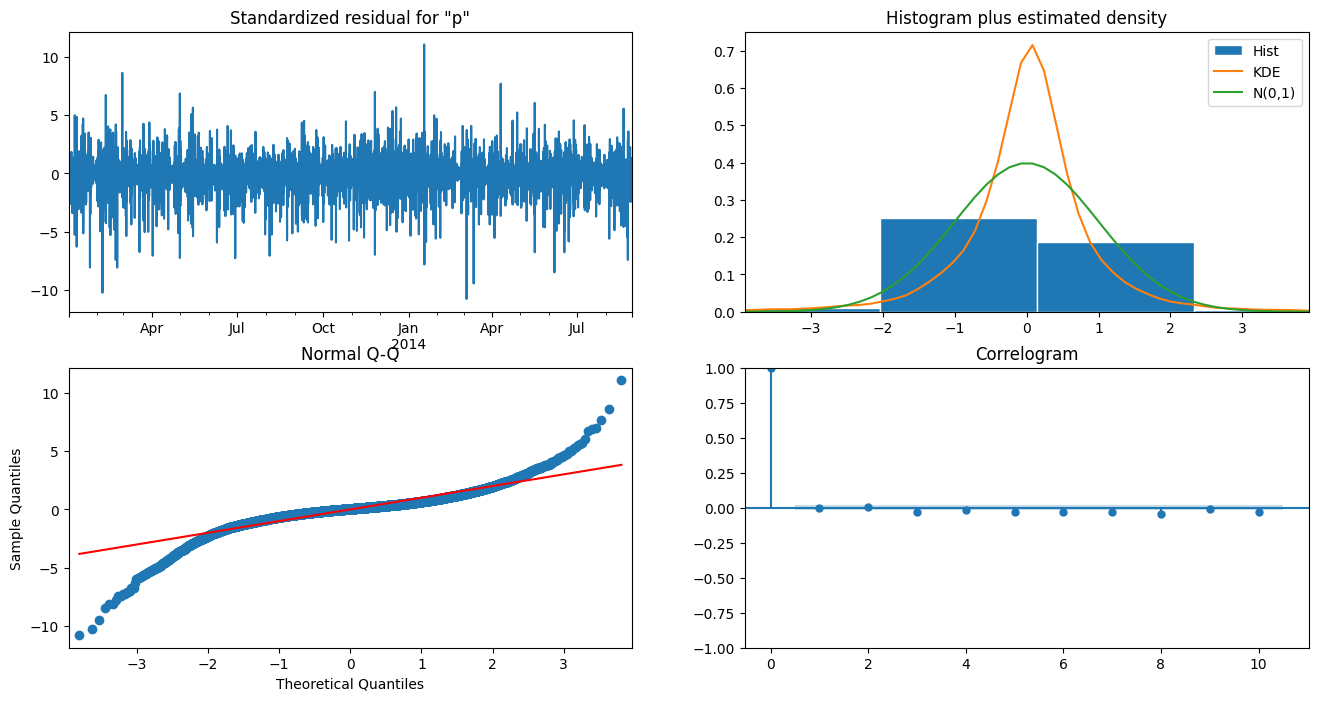

In [77]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Comparing with the first case without exogenous variables, it has a smaller AIC value, so the model shoudl be more reliable.

In [78]:
# Generate predictions
forecast = results.get_prediction(start=-100).predicted_mean
# Evaluation
mae = mean_absolute_error(forecast,train['pm2.5_log'][-100:])
mse = mean_squared_error(forecast, train['pm2.5_log'][-100:])
print(mae)
print(mse)

0.20234598462939146
0.07074458794830314


Comparing with the first case, we get smaller mae and mse. So including exogenous variables indeed improve the model's performance.